# Fit Convergent Cross Mapping Model to Data Sets

In [63]:
import pandas as pd
import numpy as np
import skccm as ccm
import matplotlib.pyplot as plt
import seaborn as sns
from skccm.utilities import train_test_split
from teaspoon.parameter_selection.FNN_n import FNN_n

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [64]:
# from 2012-2020 9 years in total, 12 months for each year
merged_df = pd.read_csv('./data/merged_data.csv',index_col=0)
merged_df = merged_df.sort_values(by=['year','month'],ascending=[True, True])
merged_df.shape

(4644, 11)

In [65]:
merged_df.head()

,USstate,year,month,nTweets_x,nTweets_y,Number of establishments (ESTAB),abbr,full,population,actual_rape_total,cost_of_living_index
0,al,2012,1,51744.000000,3.00,367.0,al,Alabama,4834334,106,71.180000
108,ak,2012,1,20125.600000,1.35,101.0,ak,Alaska,735190,39,77.304376
216,az,2012,1,57016.090909,1.00,208.0,az,Arizona,6572455,205,92.889410
324,ar,2012,1,7733.000000,1.00,318.0,ar,Arkansas,2981157,108,66.683538
432,ca,2012,1,134228.000000,5.00,3733.0,ca,California,38183375,671,65.724957


### Part A: Check the data on statewise

In [66]:
state_list = list(set(merged_df['USstate'].to_list()))
print(len(state_list))

43


#### Cost of living data

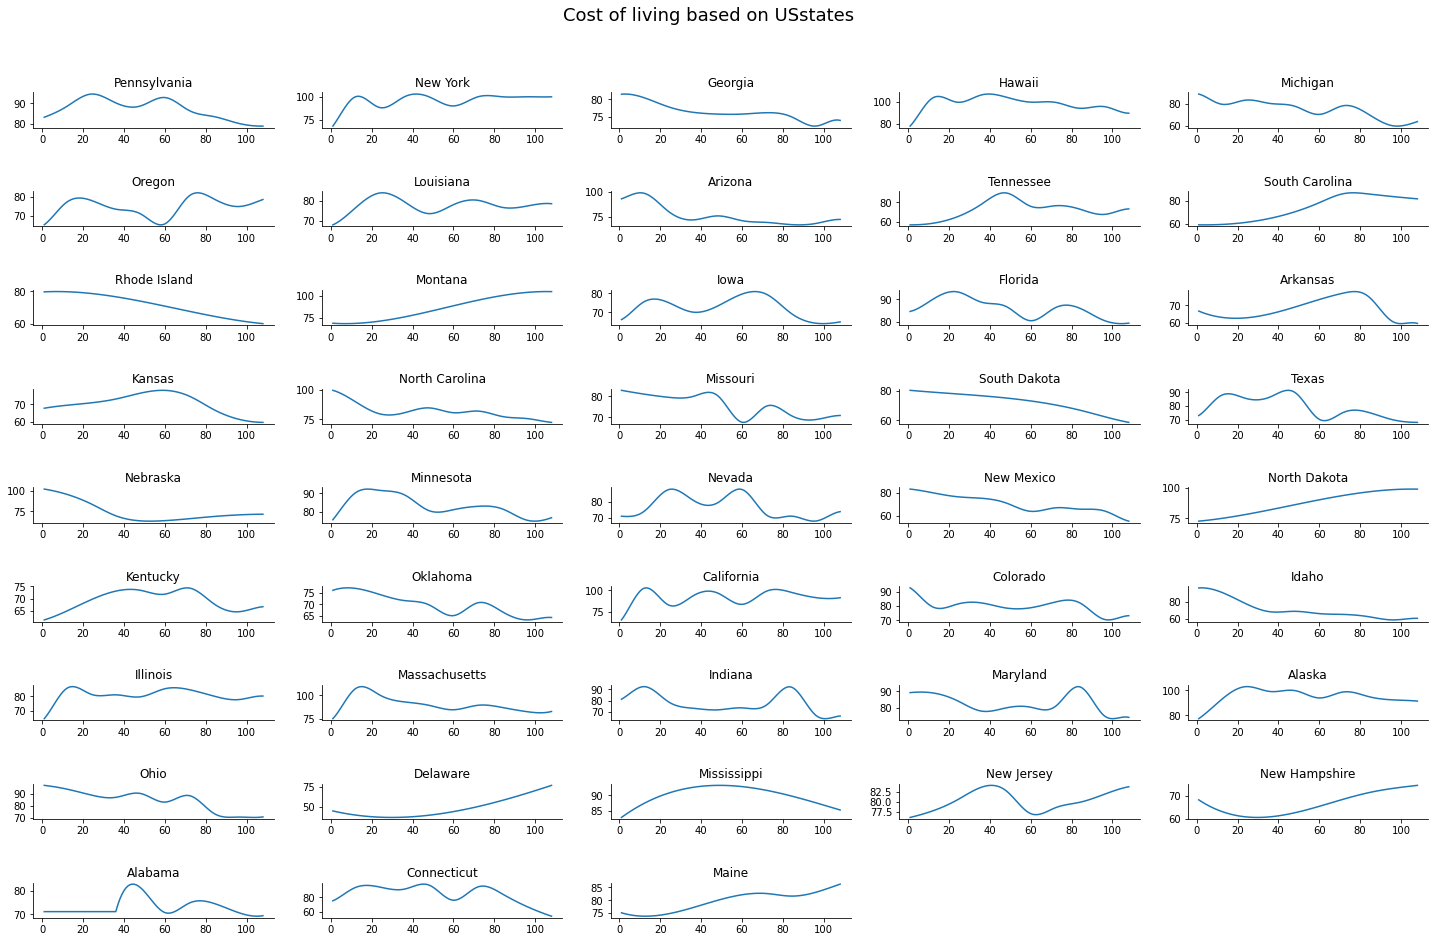

In [67]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Cost of living based on USstates", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_df[merged_df['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    x1_cost_of_living = data['cost_of_living_index'].to_numpy()
    

    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(np.arange(1,109),x1_cost_of_living)
    ax.set_title(curr_state)
    sns.despine()

### Step 2. Fit the CCM model

#### (1) Crime data VS Cost of living

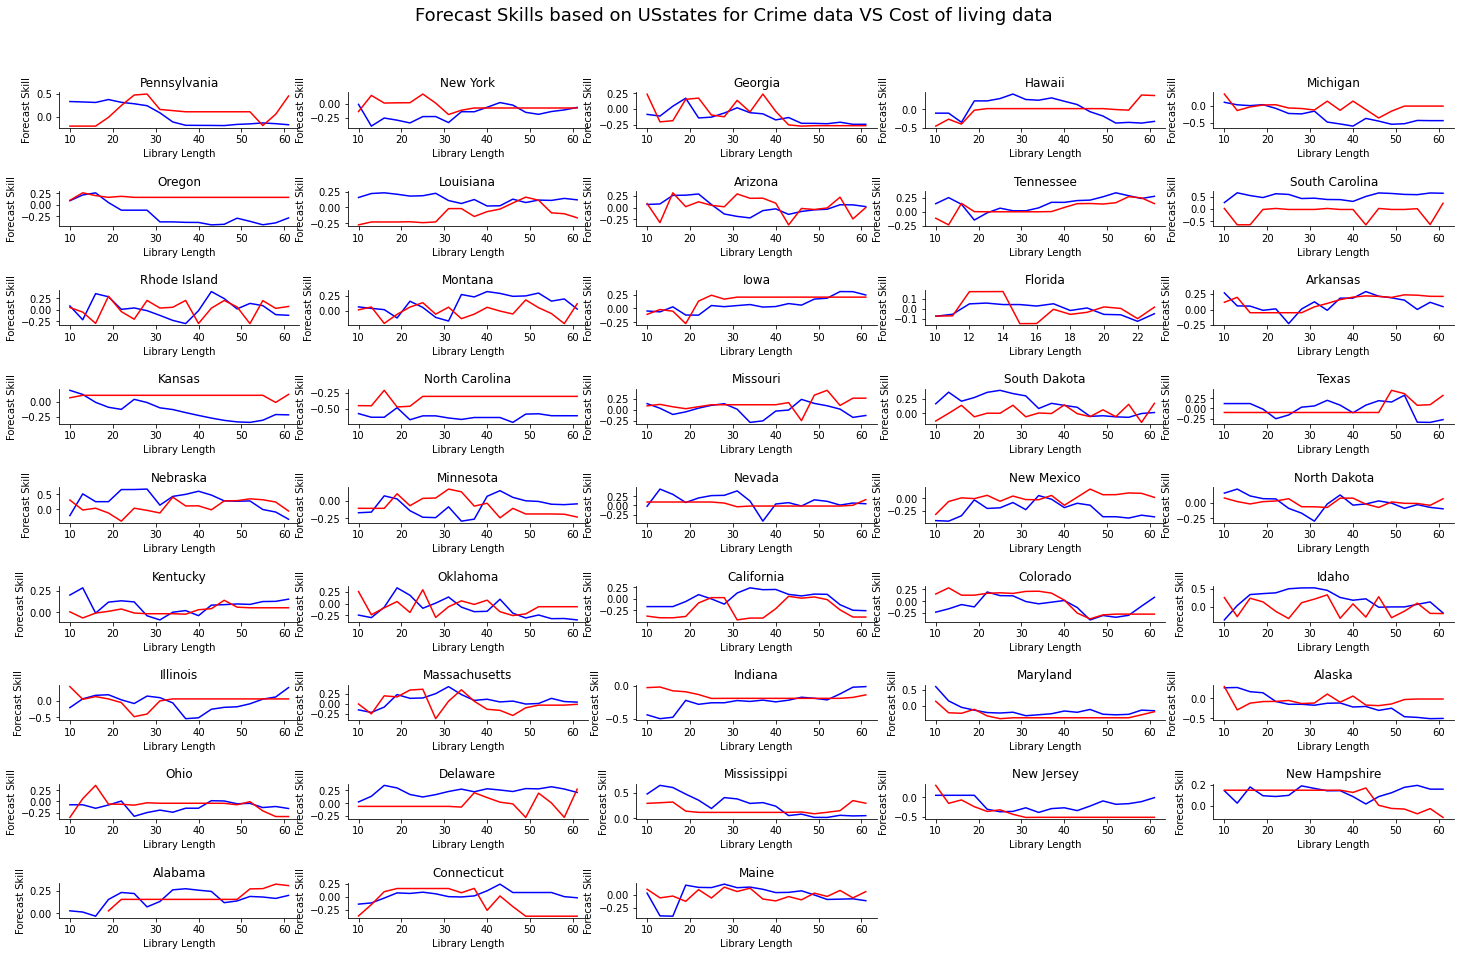

In [68]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Forecast Skills based on USstates for Crime data VS Cost of living data", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_df[merged_df['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['misogyny_proportion'] = data['nTweets_y'] / data['nTweets_x']
    
    # 0. extract data
    x1_cost_of_living = data['cost_of_living_index'].to_numpy()
    x2_crime = data['actual_rape_total'].to_numpy()
    
    # 1. Calculate Mutual information
    e1 = ccm.Embed(x1_cost_of_living)
    e2 = ccm.Embed(x2_crime)

    mi1 = e1.mutual_information(10)
    mi2 = e2.mutual_information(10)
               
    min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
    min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
    min_index1 = max(min_index1, 1)
    min_index2 = max(min_index2, 1)
    lag = max(min_index1, min_index2)
    
    # 2. Embed the time series
    perc_FNN, embed = FNN_n(x2_crime, lag, plotting = False)
    X1 = e1.embed_vectors_1d(lag,embed)
    X2 = e2.embed_vectors_1d(lag,embed)
    
    # 3. Forecast skill as a function of library length
    # split the embedded time series
    x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

    CCM = ccm.CCM() # initiate the class

    # library lengths to test
    len_tr = len(x1tr)
    lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')
    
    # test causation
    CCM.fit(x1tr,x2tr)
    x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)
    
    sc1,sc2 = CCM.score()
    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # alcohol predict crime
    ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # crime predict alcohol
    ax.set_xlabel('Library Length')
    ax.set_ylabel('Forecast Skill')
    ax.set_title(curr_state)
    sns.despine()

#### (2). Shifted Crime VS Cost of living

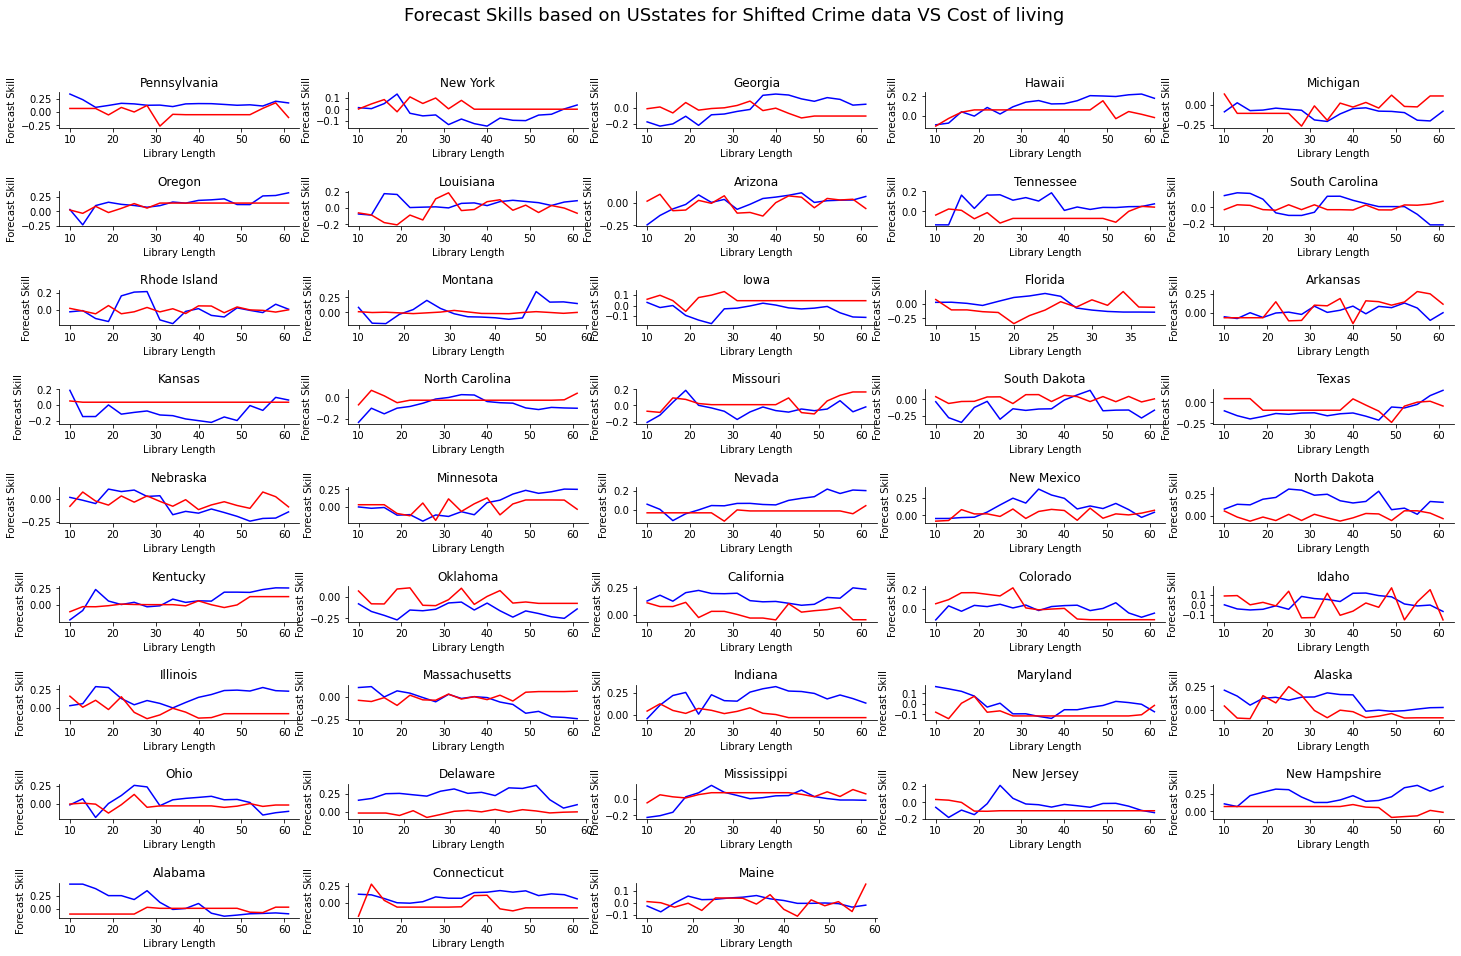

In [69]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Forecast Skills based on USstates for Shifted Crime data VS Cost of living", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_df[merged_df['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['shifted_rape_total'] = data['actual_rape_total'] - data['actual_rape_total'].shift(-1)
    data['shifted_rape_total'] = data['shifted_rape_total'].fillna(0)
    data['misogyny_proportion'] = data['nTweets_y'] / data['nTweets_x']
    
    # 0. extract data
    x1_cost_of_living = data["cost_of_living_index"].to_numpy()
    x2_rape_total = data['shifted_rape_total'].to_numpy()
    
    # 1. Calculate Mutual information
    e1 = ccm.Embed(x1_cost_of_living)
    e2 = ccm.Embed(x2_rape_total)

    mi1 = e1.mutual_information(10)
    mi2 = e2.mutual_information(10)
               
    min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
    min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
    min_index1 = max(min_index1, 1)
    min_index2 = max(min_index2, 1)
    lag = max(min_index1, min_index2)
    
    # 2. Embed the time series
    perc_FNN, embed = FNN_n(x2_rape_total, lag, plotting = False)
    X1 = e1.embed_vectors_1d(lag,embed)
    X2 = e2.embed_vectors_1d(lag,embed)
    
    # 3. Forecast skill as a function of library length
    # split the embedded time series
    x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

    CCM = ccm.CCM() # initiate the class

    # library lengths to test
    len_tr = len(x1tr)
    lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')
    
    # test causation
    CCM.fit(x1tr,x2tr)
    x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)
    
    sc1,sc2 = CCM.score()
    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # alcohol predict crime
    ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # crime predict alcohol
    ax.set_xlabel('Library Length')
    ax.set_ylabel('Forecast Skill')
    ax.set_title(curr_state)
    sns.despine()

#### (3) Tweets VS Cost of living

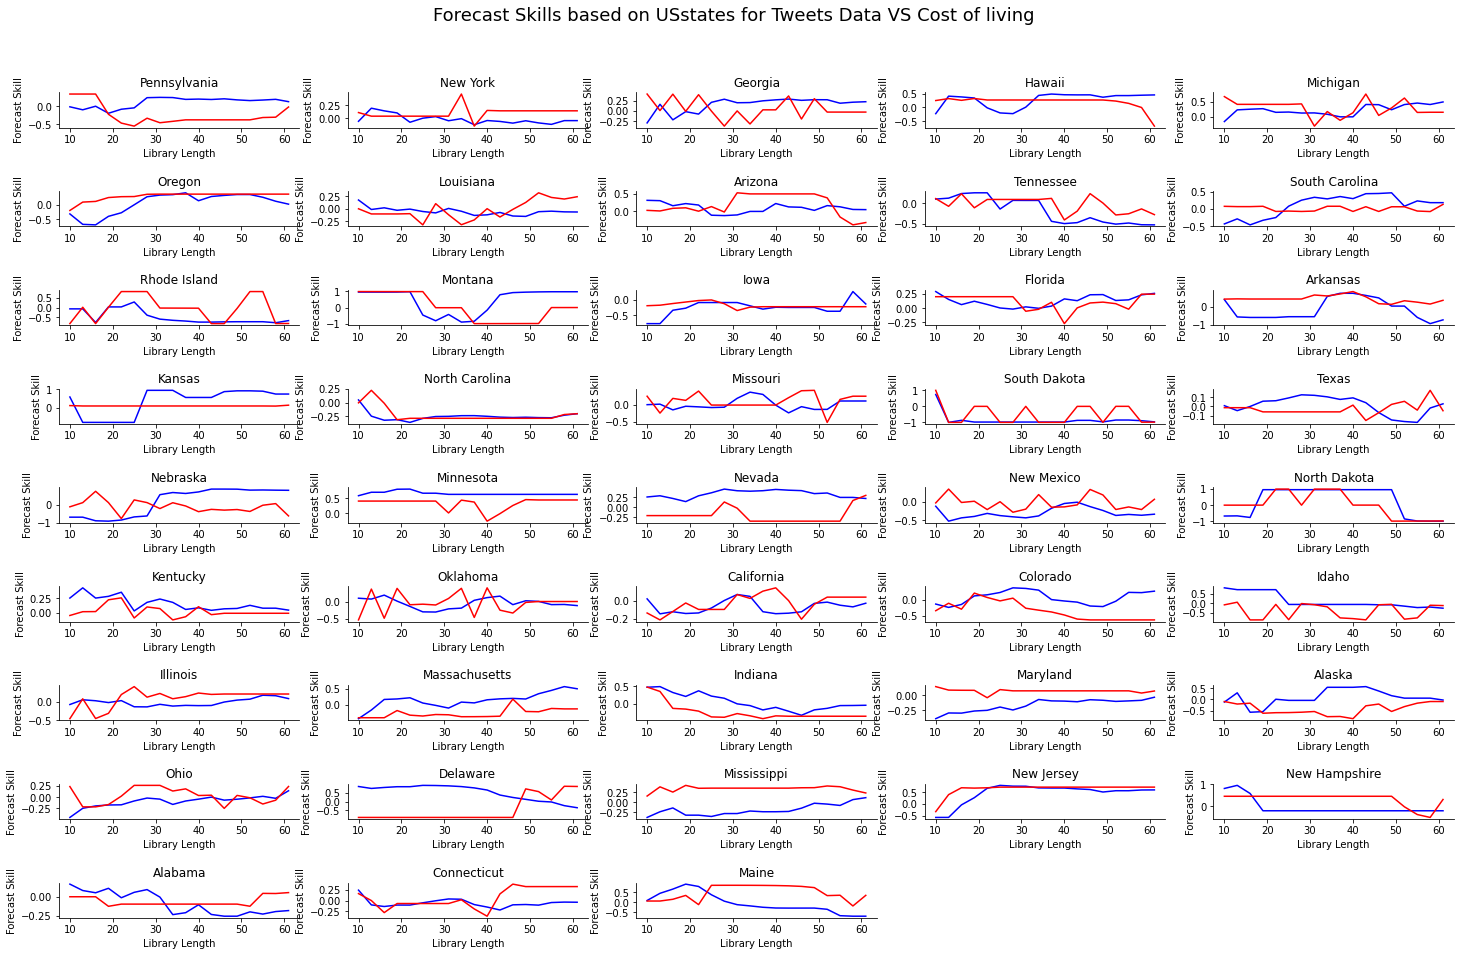

In [70]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Forecast Skills based on USstates for Tweets Data VS Cost of living", fontsize=18, y=0.95)

for i in range(len(state_list)):
    data = merged_df[merged_df['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['misogyny_proportion'] = data['nTweets_y'] / data['nTweets_x']
    
    # 0. extract data
    x1_cost_of_living = data["cost_of_living_index"].to_numpy()
    x2_tweet = data['misogyny_proportion'].to_numpy()
    
    # 1. Calculate Mutual information
    e1 = ccm.Embed(x1_cost_of_living)
    e2 = ccm.Embed(x2_tweet)

    mi1 = e1.mutual_information(10)
    mi2 = e2.mutual_information(10)
               
    min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
    min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
    min_index1 = max(min_index1, 1)
    min_index2 = max(min_index2, 1)
    lag = max(min_index1, min_index2)
    
    # 2. Embed the time series
    perc_FNN, embed = FNN_n(x2_tweet, lag, plotting = False)
    X1 = e1.embed_vectors_1d(lag,embed)
    X2 = e2.embed_vectors_1d(lag,embed)
    
    # 3. Forecast skill as a function of library length
    # split the embedded time series
    x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

    CCM = ccm.CCM() # initiate the class

    # library lengths to test
    len_tr = len(x1tr)
    lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')
    
    # test causation
    CCM.fit(x1tr,x2tr)
    x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)
    
    sc1,sc2 = CCM.score()
    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # alcohol predict tweets
    ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # tweets predict alcohol
    ax.set_xlabel('Library Length')
    ax.set_ylabel('Forecast Skill')
    ax.set_title(curr_state)
    sns.despine()

### Part B: base on the countrywise

In [71]:
merged_data_use = merged_df.copy()
merged_data_use['misogyny_proportion'] = merged_data_use['nTweets_y'] / merged_data_use['nTweets_x']
merged_data_use = merged_data_use.groupby(['year','month']).sum()
merged_data_use['shifted_rape_total'] = merged_data_use['actual_rape_total'] - merged_data_use['actual_rape_total'].shift(-1)
merged_data_use['shifted_rape_total'] = merged_data_use['shifted_rape_total'].fillna(0)
merged_data_use
#merged_data_use = merged_data_use.drop(columns=['nTweets_x','nTweets_y','population','Number of establishments (ESTAB)'])

merged_data_use = merged_data_use[['cost_of_living_index', 'misogyny_proportion','actual_rape_total', 'shifted_rape_total']]
merged_data_use

cost_of_living_index  misogyny_proportion  actual_rape_total  \
year month                                                                 
2012 1               3285.358551             0.002436               5809   
     2               3304.157739             0.002360               5290   
     3               3325.007633             0.002384               6175   
     4               3347.279078             0.003232               5738   
     5               3370.342921             0.003256               6002   
...                          ...                  ...                ...   
2020 8               3207.267434             0.001755               9146   
     9               3210.244382             0.001784               8744   
     10              3213.117666             0.001793               8240   
     11              3215.626260             0.001789               7364   
     12              3217.509137             0.001820              14072   

            shifted_rape_total  
year month                      
2012 1                   519.0  
     2                  -885.0  
     3                   437.0  
     4                  -264.0  
     5                  -982.0  
...                        ...  
2020 8                   402.0  
     9                   504.0  
     10                  876.0  
     11                -6708.0  
     12                    0.0  

[108 rows x 4 columns]

### 1. Extract data

In [72]:
x1_cost_of_living = merged_data_use['cost_of_living_index'].to_numpy()
x2_crime = merged_data_use['actual_rape_total'].to_numpy()
x3_tweet = merged_data_use['misogyny_proportion'].to_numpy()
x4_shifted_crime = merged_data_use['shifted_rape_total'].to_numpy()

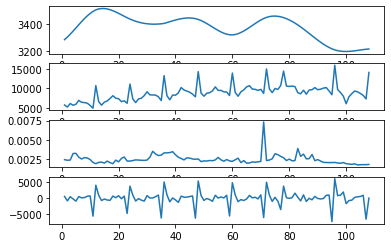

In [91]:
fig,ax = plt.subplots(nrows=4,sharex=False,sharey=False)
ax[0].plot(np.arange(1,109),x1_cost_of_living)
ax[1].plot(np.arange(1,109),x2_crime)
ax[2].plot(np.arange(1,109),x3_tweet)
ax[3].plot(np.arange(1,109),x4_shifted_crime)

In [74]:
corr = merged_data_use.corr()         #reference correlation
corr

,cost_of_living_index,misogyny_proportion,actual_rape_total,shifted_rape_total
cost_of_living_index,1.000000,0.288777,-0.159612,0.022099
misogyny_proportion,0.288777,1.000000,-0.057513,-0.178958
actual_rape_total,-0.159612,-0.057513,1.000000,0.540797
shifted_rape_total,0.022099,-0.178958,0.540797,1.000000


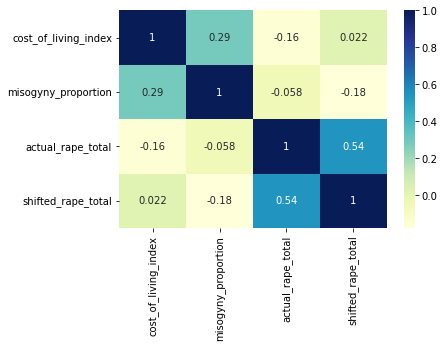

In [75]:
dataplot = sns.heatmap(corr,cmap="YlGnBu", annot=True)

### 2. Crime VS cost of living 

#### (1) Calculate Mutual information

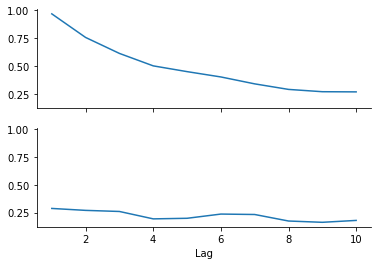

In [76]:
e1 = ccm.Embed(x1_cost_of_living)
e2 = ccm.Embed(x2_crime)

mi1 = e1.mutual_information(10)
mi2 = e2.mutual_information(10)

fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(np.arange(1,11),mi1)
ax[1].plot(np.arange(1,11),mi2)
ax[1].set_xlabel('Lag')
sns.despine()

#### (2). Embed the time series

9


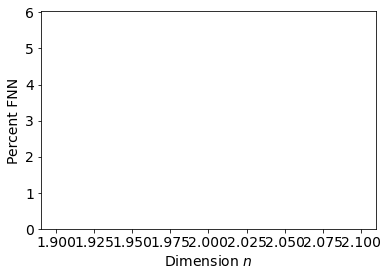

FNN embedding Dimension:  2


In [77]:
min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
min_index1 = max(min_index1, 1)
min_index2 = max(min_index2, 1)
lag = max(min_index1, min_index2)
print(lag)

perc_FNN, embed = FNN_n(x2_crime, lag, plotting = True)
print('FNN embedding Dimension: ',embed)
X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

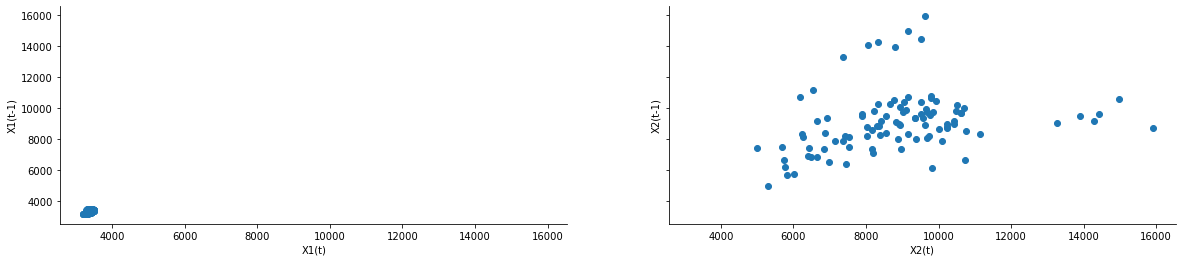

In [78]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(20,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

#### (3). Forecast skill as a function of library length

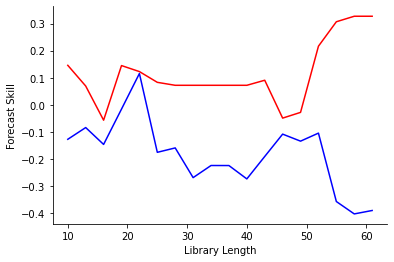

In [79]:
#split the embedded time series
x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

CCM = ccm.CCM() #initiate the class

#library lengths to test
len_tr = len(x1tr)
lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

#test causation
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

sc1,sc2 = CCM.score()

# plot
fig,ax = plt.subplots()
ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # cost of living predict crime
ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # crime predict cost of living
ax.set_xlabel('Library Length')
ax.set_ylabel('Forecast Skill')
sns.despine()

### 3. Shifted Crime VS cost of living 

#### (1). Calculate Mutual information

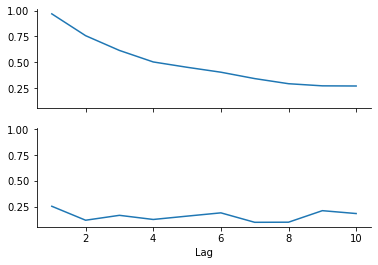

In [80]:
e1 = ccm.Embed(x1_cost_of_living)
e2 = ccm.Embed(x4_shifted_crime)

mi1 = e1.mutual_information(10)
mi2 = e2.mutual_information(10)

fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(np.arange(1,11),mi1)
ax[1].plot(np.arange(1,11),mi2)
ax[1].set_xlabel('Lag')
sns.despine()

#### (2). Embed the time series

9


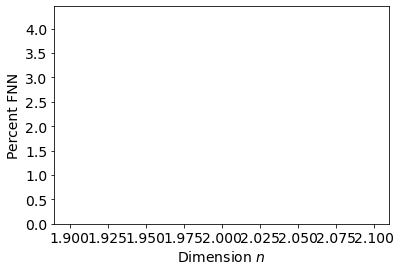

FNN embedding Dimension:  2


In [81]:
from pickle import FALSE


min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
min_index1 = max(min_index1, 1)
min_index2 = max(min_index2, 1)
lag = max(min_index1, min_index2)
print(lag)


perc_FNN, embed = FNN_n(x4_shifted_crime, lag, plotting = True)
print('FNN embedding Dimension: ',embed)
X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

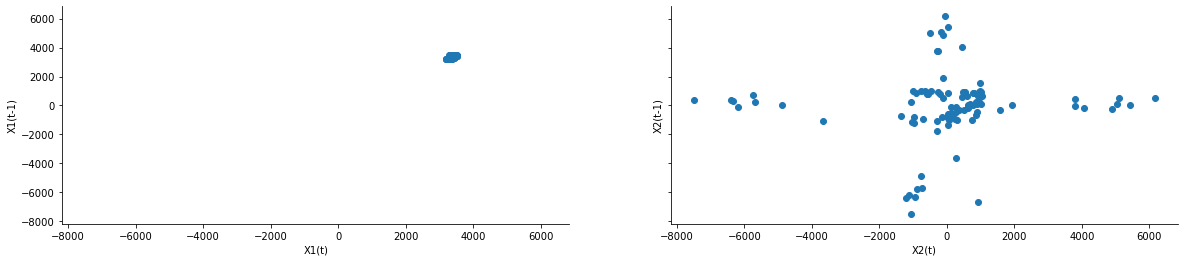

In [82]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(20,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

#### (3). Forecast skill as a function of library length

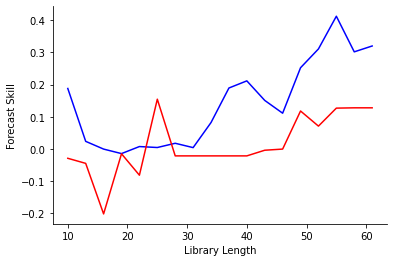

In [83]:
#split the embedded time series
x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

CCM = ccm.CCM() #initiate the class

#library lengths to test
len_tr = len(x1tr)
lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

#test causation
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

sc1,sc2 = CCM.score()

# plot
fig,ax = plt.subplots()
ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # cost of living predict shifted crime
ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # shifted crime predict cost of living 
ax.set_xlabel('Library Length')
ax.set_ylabel('Forecast Skill')
sns.despine()

### 4. Tweets VS cost of living 

#### (1). Calculate Mutual information

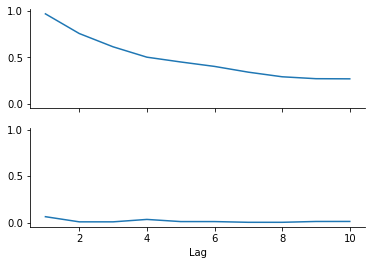

In [84]:
e1 = ccm.Embed(x1_cost_of_living)
e2 = ccm.Embed(x3_tweet)

mi1 = e1.mutual_information(10)
mi2 = e2.mutual_information(10)

fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(np.arange(1,11),mi1)
ax[1].plot(np.arange(1,11),mi2)
ax[1].set_xlabel('Lag')
sns.despine()

#### (2). Embed the time series

9


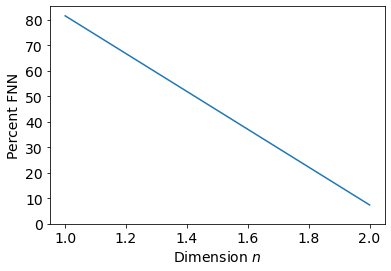

FNN embedding Dimension:  2


In [85]:
min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
min_index1 = max(min_index1, 1)
min_index2 = max(min_index2, 1)
lag = max(min_index1, min_index2)
print(lag)

perc_FNN, embed = FNN_n(x3_tweet, lag, plotting = True)
print('FNN embedding Dimension: ',embed)
X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

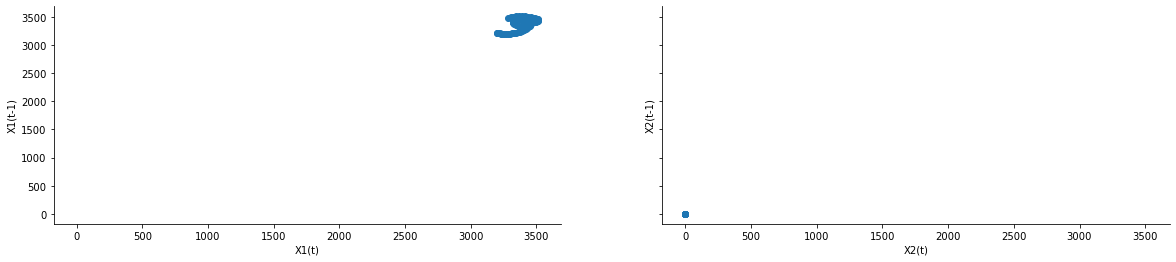

In [86]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(20,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

#### (3). Forecast skill as a function of library length

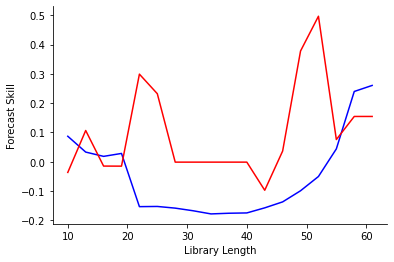

In [87]:
#split the embedded time series
x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

CCM = ccm.CCM() #initiate the class

#library lengths to test
len_tr = len(x1tr)
lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

#test causation
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

sc1,sc2 = CCM.score()

# plot
fig,ax = plt.subplots()
ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # cost of living predict tweets
ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # tweets predict cost of living
ax.set_xlabel('Library Length')
ax.set_ylabel('Forecast Skill')
sns.despine()